In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import os
os.chdir('/content/drive/MyDrive/ml4qs/')

In [3]:
!pip install optuna
!pip install tensorflow


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 10.0 MB/s eta 0:00:00


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import optuna

In [5]:
# Load the dataset
full_data = pd.read_parquet("full_dataset.parquet.gzip")
full_data = full_data[full_data["SM_platform"] != "Red"]

In [6]:
# Split the dataset into training and testing sets
random.seed(51)
testing_categories = [1, 2, 3, 4, 5, 6]
random.shuffle(testing_categories)

testing_set = [f"{platform}{number}" for platform, number in zip(full_data["SM_platform"].unique(), testing_categories)]
testing_df = full_data[full_data["source_name"].isin(testing_set)]
training_df = full_data[~full_data["source_name"].isin(testing_set)]

In [7]:
# Only select standardized columns
columns_to_select = [col for col in full_data.columns if 'zscore' in col] + ["SM_platform", "index"] + [col for col in
                                                                                                        full_data.columns
                                                                                                        if 'pc' in col]
training_df = training_df.loc[:, columns_to_select]
testing_df = testing_df.loc[:, columns_to_select]

In [8]:
# Separate features and target
X_train = training_df.drop(columns=["SM_platform"])
y_train = training_df["SM_platform"]
X_test = testing_df.drop(columns=["SM_platform"])
y_test = testing_df["SM_platform"]

# Encode the target variable
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# # Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# reshape data for LSTM (samples, time_steps, features)
X_train = np.expand_dims(X_train.values, axis=2)
X_test = np.expand_dims(X_test.values, axis=2)

In [9]:
# Create sequences for LSTM
def create_sequences(data, target, sequence_length):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length])
        labels.append(target[i + sequence_length])
    return np.array(sequences), np.array(labels)


sequence_length = 10  # Example sequence length
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_encoded, sequence_length)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_encoded, sequence_length)

In [10]:
# Define the LSTM model
def create_model(trial):
    model = Sequential()
    model.add(LSTM(units=trial.suggest_int('units_1', 32, 128), return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(trial.suggest_float('dropout_1', 0.2, 0.5)))
    model.add(LSTM(units=trial.suggest_int('units_2', 16, 64)))
    model.add(Dropout(trial.suggest_float('dropout_2', 0.2, 0.5)))
    model.add(Dense(units=trial.suggest_int('dense_units', 32, 128), activation='relu'))
    model.add(Dense(units=len(label_encoder.classes_), activation='softmax'))

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=trial.suggest_float('learning_rate', 1e-4, 1e-2)),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [11]:
def objective(trial):
    model = create_model(trial)
    history = model.fit(X_train, y_train_encoded, validation_data=(X_test, y_test_encoded),
                        epochs=10, batch_size=trial.suggest_int('batch_size', 32, 128), verbose=0)

    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)
    accuracy = accuracy_score(y_test_encoded, y_pred)

    return accuracy

default training

In [12]:
# Define the LSTM model with default hyperparameters
def create_default_model():
    model = Sequential()
    model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(units=100, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=25, activation='relu'))
    model.add(Dense(units=len(label_encoder.classes_), activation='softmax'))

    optimizer = Adam(learning_rate=1e-3)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

In [13]:
# Train the model with default hyperparameters
default_model = create_default_model()
history = default_model.fit(X_train_seq, y_train_seq, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/50
3727/3727 [==============================] - 27s 6ms/step - loss: 0.0212 - accuracy: 0.9937 - val_loss: 9.9175 - val_accuracy: 0.0012
Epoch 2/50
3727/3727 [==============================] - 21s 6ms/step - loss: 0.0037 - accuracy: 0.9991 - val_loss: 16.5558 - val_accuracy: 0.0012
Epoch 3/50
3727/3727 [==============================] - 21s 6ms/step - loss: 0.0043 - accuracy: 0.9990 - val_loss: 14.5484 - val_accuracy: 0.0012
Epoch 4/50
3727/3727 [==============================] - 21s 6ms/step - loss: 0.0025 - accuracy: 0.9994 - val_loss: 16.6237 - val_accuracy: 0.0012
Epoch 5/50
3727/3727 [==============================] - 21s 6ms/step - loss: 4.2279e-04 - accuracy: 1.0000 - val_loss: 21.5056 - val_accuracy: 0.0012
Epoch 6/50
3727/3727 [==============================] - 21s 6ms/step - loss: 0.0024 - accuracy: 0.9994 - val_loss: 26.5830 - val_accuracy: 0.0012
Epoch 7/50
3727/3727 [==============================] - 21s 6ms/step - loss: 0.0011 - accuracy: 0.9997 - val_loss: 31.417

In [14]:
# Evaluate the model
test_loss, test_accuracy = default_model.evaluate(X_test_seq, y_test_seq)
print(f'Test Accuracy: {test_accuracy:.4f}')

932/932 [==============================] - 2s 3ms/step - loss: 10.0662 - accuracy: 0.6074
Test Accuracy: 0.6074


In [15]:
# Predict and generate confusion matrix
y_pred = default_model.predict(X_test_seq)
y_pred_classes = np.argmax(y_pred, axis=1)

932/932 [==============================] - 3s 2ms/step


In [16]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test_seq, y_pred_classes)
print('Confusion Matrix:')
print(conf_matrix)

Confusion Matrix:
[[5986    0    0    0    0]
 [   7 5944    0    0    0]
 [   0   14  771 5170    0]
 [   0    0  554 5401    0]
 [4677 1138  126   14    0]]


In [17]:
# Classification Report
class_report = classification_report(y_test_seq, y_pred_classes, target_names=label_encoder.classes_)
print('Classification Report:')
print(class_report)

Classification Report:
              precision    recall  f1-score   support

          FB       0.56      1.00      0.72      5986
       Insta       0.84      1.00      0.91      5951
      Reddit       0.53      0.13      0.21      5955
      TikTok       0.51      0.91      0.65      5955
           X       0.00      0.00      0.00      5955

    accuracy                           0.61     29802
   macro avg       0.49      0.61      0.50     29802
weighted avg       0.49      0.61      0.50     29802



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


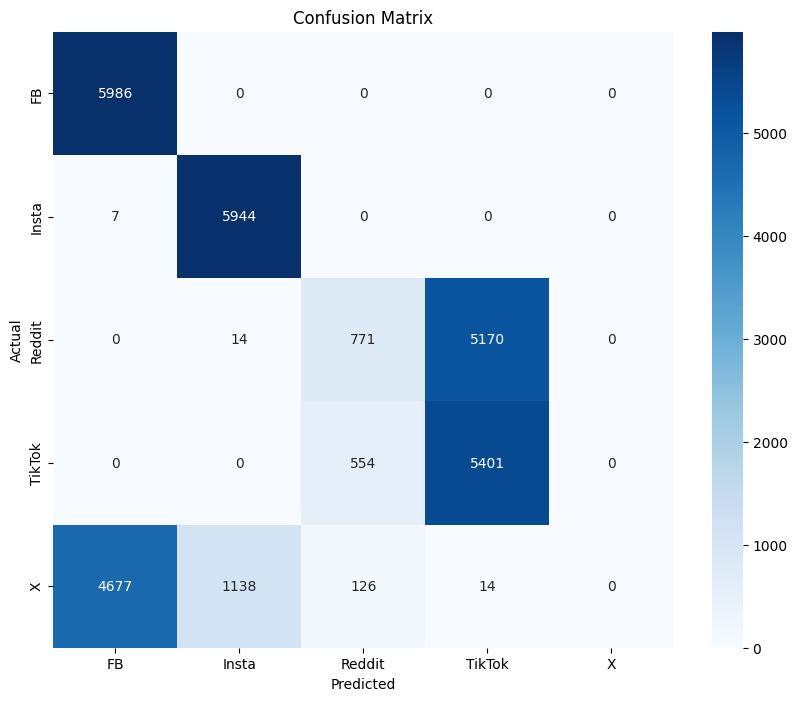

In [18]:
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

hyperparameter tuning with optuna

In [19]:
# Run Optuna optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2024-06-21 15:32:24,458] A new study created in memory with name: no-name-b6b2ef5d-419c-4350-bb20-a0c82da4a791


932/932 [==============================] - 4s 4ms/step


[I 2024-06-21 15:38:19,281] Trial 0 finished with value: 0.7183013551589964 and parameters: {'units_1': 38, 'dropout_1': 0.37246950302711823, 'units_2': 32, 'dropout_2': 0.35365620972693196, 'dense_units': 82, 'learning_rate': 0.009461159538605522, 'batch_size': 34}. Best is trial 0 with value: 0.7183013551589964.


932/932 [==============================] - 4s 4ms/step


[I 2024-06-21 15:41:19,531] Trial 1 finished with value: 0.7496981081443714 and parameters: {'units_1': 107, 'dropout_1': 0.40786604299942136, 'units_2': 17, 'dropout_2': 0.45284166350310295, 'dense_units': 97, 'learning_rate': 0.0017894135140075278, 'batch_size': 74}. Best is trial 1 with value: 0.7496981081443714.


932/932 [==============================] - 4s 4ms/step


[I 2024-06-21 15:44:24,067] Trial 2 finished with value: 0.8035019455252919 and parameters: {'units_1': 42, 'dropout_1': 0.47743629120281256, 'units_2': 22, 'dropout_2': 0.21732912585274483, 'dense_units': 48, 'learning_rate': 0.005031226965935945, 'batch_size': 71}. Best is trial 2 with value: 0.8035019455252919.


932/932 [==============================] - 4s 4ms/step


[I 2024-06-21 15:46:58,481] Trial 3 finished with value: 0.7539916812022005 and parameters: {'units_1': 77, 'dropout_1': 0.4451315375173272, 'units_2': 25, 'dropout_2': 0.22166835301286025, 'dense_units': 101, 'learning_rate': 0.0005432294005924965, 'batch_size': 86}. Best is trial 2 with value: 0.8035019455252919.


932/932 [==============================] - 4s 4ms/step


[I 2024-06-21 15:50:03,591] Trial 4 finished with value: 0.7621763048436871 and parameters: {'units_1': 108, 'dropout_1': 0.2864139100268909, 'units_2': 23, 'dropout_2': 0.4970628081452521, 'dense_units': 63, 'learning_rate': 0.005060963199066039, 'batch_size': 72}. Best is trial 2 with value: 0.8035019455252919.


932/932 [==============================] - 4s 4ms/step


[I 2024-06-21 15:54:08,926] Trial 5 finished with value: 0.398866228364417 and parameters: {'units_1': 102, 'dropout_1': 0.37547414210680335, 'units_2': 17, 'dropout_2': 0.296139656003091, 'dense_units': 50, 'learning_rate': 0.0073361838166584505, 'batch_size': 54}. Best is trial 2 with value: 0.8035019455252919.


932/932 [==============================] - 4s 4ms/step


[I 2024-06-21 15:56:14,404] Trial 6 finished with value: 0.7916275325372333 and parameters: {'units_1': 50, 'dropout_1': 0.3112645807009918, 'units_2': 30, 'dropout_2': 0.46809754896189215, 'dense_units': 65, 'learning_rate': 0.0033489995313840315, 'batch_size': 106}. Best is trial 2 with value: 0.8035019455252919.


932/932 [==============================] - 4s 4ms/step


[I 2024-06-21 16:00:36,879] Trial 7 finished with value: 0.6884140614517644 and parameters: {'units_1': 117, 'dropout_1': 0.34978452723756603, 'units_2': 45, 'dropout_2': 0.3711238365838101, 'dense_units': 69, 'learning_rate': 0.006829344752096514, 'batch_size': 50}. Best is trial 2 with value: 0.8035019455252919.


932/932 [==============================] - 4s 4ms/step


[I 2024-06-21 16:03:13,658] Trial 8 finished with value: 0.7141419562592245 and parameters: {'units_1': 83, 'dropout_1': 0.24344518939583032, 'units_2': 40, 'dropout_2': 0.34159877725460364, 'dense_units': 81, 'learning_rate': 0.008513328669471831, 'batch_size': 87}. Best is trial 2 with value: 0.8035019455252919.


932/932 [==============================] - 4s 4ms/step


[I 2024-06-21 16:05:04,557] Trial 9 finished with value: 0.7897490943244331 and parameters: {'units_1': 92, 'dropout_1': 0.2592106015423657, 'units_2': 49, 'dropout_2': 0.25773601965987814, 'dense_units': 50, 'learning_rate': 0.007463152385624908, 'batch_size': 127}. Best is trial 2 with value: 0.8035019455252919.


932/932 [==============================] - 4s 4ms/step


[I 2024-06-21 16:07:15,462] Trial 10 finished with value: 0.796457802227291 and parameters: {'units_1': 62, 'dropout_1': 0.4912243540191433, 'units_2': 38, 'dropout_2': 0.2017200494507796, 'dense_units': 35, 'learning_rate': 0.00444732523806445, 'batch_size': 102}. Best is trial 2 with value: 0.8035019455252919.


932/932 [==============================] - 4s 4ms/step


[I 2024-06-21 16:09:14,659] Trial 11 finished with value: 0.7804575338789749 and parameters: {'units_1': 61, 'dropout_1': 0.48647059955206856, 'units_2': 61, 'dropout_2': 0.20120436459411067, 'dense_units': 32, 'learning_rate': 0.004173214965383318, 'batch_size': 113}. Best is trial 2 with value: 0.8035019455252919.


932/932 [==============================] - 4s 4ms/step


[I 2024-06-21 16:11:27,010] Trial 12 finished with value: 0.7449013819938279 and parameters: {'units_1': 62, 'dropout_1': 0.49797020327741187, 'units_2': 37, 'dropout_2': 0.2614810873014678, 'dense_units': 32, 'learning_rate': 0.005191446790267786, 'batch_size': 100}. Best is trial 2 with value: 0.8035019455252919.


932/932 [==============================] - 4s 3ms/step


[I 2024-06-21 16:14:40,216] Trial 13 finished with value: 0.8207433248356366 and parameters: {'units_1': 36, 'dropout_1': 0.4412334015377209, 'units_2': 49, 'dropout_2': 0.24621854278816105, 'dense_units': 123, 'learning_rate': 0.0030470531114485046, 'batch_size': 67}. Best is trial 13 with value: 0.8207433248356366.


932/932 [==============================] - 5s 4ms/step


[I 2024-06-21 16:18:23,858] Trial 14 finished with value: 0.8273178585804374 and parameters: {'units_1': 32, 'dropout_1': 0.43372040369190307, 'units_2': 55, 'dropout_2': 0.2968639463356105, 'dense_units': 125, 'learning_rate': 0.0026907883594303916, 'batch_size': 57}. Best is trial 14 with value: 0.8273178585804374.


932/932 [==============================] - 4s 4ms/step


[I 2024-06-21 16:22:07,736] Trial 15 finished with value: 0.7542264859788005 and parameters: {'units_1': 32, 'dropout_1': 0.41674428673993147, 'units_2': 56, 'dropout_2': 0.30514430848348995, 'dense_units': 128, 'learning_rate': 0.0024324656009068577, 'batch_size': 57}. Best is trial 14 with value: 0.8273178585804374.


932/932 [==============================] - 4s 4ms/step


[I 2024-06-21 16:27:53,697] Trial 16 finished with value: 0.7131356500737958 and parameters: {'units_1': 48, 'dropout_1': 0.20683714400795816, 'units_2': 52, 'dropout_2': 0.4043557778921036, 'dense_units': 128, 'learning_rate': 0.00032943760356963364, 'batch_size': 36}. Best is trial 14 with value: 0.8273178585804374.


932/932 [==============================] - 4s 4ms/step


[I 2024-06-21 16:31:20,214] Trial 17 finished with value: 0.7412786797262847 and parameters: {'units_1': 32, 'dropout_1': 0.4406629319117379, 'units_2': 62, 'dropout_2': 0.2714983230850093, 'dense_units': 117, 'learning_rate': 0.0018842435319554665, 'batch_size': 62}. Best is trial 14 with value: 0.8273178585804374.


932/932 [==============================] - 4s 4ms/step


[I 2024-06-21 16:36:10,249] Trial 18 finished with value: 0.7969944988595197 and parameters: {'units_1': 53, 'dropout_1': 0.4524472122378377, 'units_2': 46, 'dropout_2': 0.31923653780217104, 'dense_units': 111, 'learning_rate': 0.0030637463482836406, 'batch_size': 44}. Best is trial 14 with value: 0.8273178585804374.


932/932 [==============================] - 4s 4ms/step


[I 2024-06-21 16:39:28,245] Trial 19 finished with value: 0.802596269958406 and parameters: {'units_1': 73, 'dropout_1': 0.407356159313201, 'units_2': 53, 'dropout_2': 0.24318004160602638, 'dense_units': 95, 'learning_rate': 0.006203707519148315, 'batch_size': 66}. Best is trial 14 with value: 0.8273178585804374.


932/932 [==============================] - 4s 4ms/step


[I 2024-06-21 16:42:10,825] Trial 20 finished with value: 0.7507379578693144 and parameters: {'units_1': 43, 'dropout_1': 0.3419409588016132, 'units_2': 57, 'dropout_2': 0.2819237589634604, 'dense_units': 115, 'learning_rate': 0.0010252055839912845, 'batch_size': 81}. Best is trial 14 with value: 0.8273178585804374.


932/932 [==============================] - 4s 4ms/step


[I 2024-06-21 16:45:29,022] Trial 21 finished with value: 0.7739165436736885 and parameters: {'units_1': 40, 'dropout_1': 0.4642147735463539, 'units_2': 46, 'dropout_2': 0.24400169097379587, 'dense_units': 108, 'learning_rate': 0.003600326318530028, 'batch_size': 65}. Best is trial 14 with value: 0.8273178585804374.


932/932 [==============================] - 4s 4ms/step


[I 2024-06-21 16:50:04,730] Trial 22 finished with value: 0.7564068160472293 and parameters: {'units_1': 55, 'dropout_1': 0.4264484243951883, 'units_2': 56, 'dropout_2': 0.2298609348437814, 'dense_units': 121, 'learning_rate': 0.006095025368145369, 'batch_size': 46}. Best is trial 14 with value: 0.8273178585804374.


932/932 [==============================] - 4s 4ms/step


[I 2024-06-21 16:52:59,932] Trial 23 finished with value: 0.784516302160204 and parameters: {'units_1': 41, 'dropout_1': 0.47142338595383254, 'units_2': 41, 'dropout_2': 0.32372657634161034, 'dense_units': 92, 'learning_rate': 0.0026809206449150613, 'batch_size': 74}. Best is trial 14 with value: 0.8273178585804374.


932/932 [==============================] - 4s 4ms/step


[I 2024-06-21 16:55:22,416] Trial 24 finished with value: 0.7721387360794311 and parameters: {'units_1': 32, 'dropout_1': 0.3909757426747477, 'units_2': 50, 'dropout_2': 0.28869577059089113, 'dense_units': 44, 'learning_rate': 0.004191925862080681, 'batch_size': 93}. Best is trial 14 with value: 0.8273178585804374.


932/932 [==============================] - 4s 4ms/step


[I 2024-06-21 16:58:57,495] Trial 25 finished with value: 0.7466791895880853 and parameters: {'units_1': 69, 'dropout_1': 0.46637538009344537, 'units_2': 33, 'dropout_2': 0.22832258250420817, 'dense_units': 107, 'learning_rate': 0.0016758402060889552, 'batch_size': 60}. Best is trial 14 with value: 0.8273178585804374.


932/932 [==============================] - 4s 4ms/step


[I 2024-06-21 17:02:00,421] Trial 26 finished with value: 0.8005836575875487 and parameters: {'units_1': 45, 'dropout_1': 0.44101720428387126, 'units_2': 23, 'dropout_2': 0.26291069684408364, 'dense_units': 75, 'learning_rate': 0.005515636424600037, 'batch_size': 71}. Best is trial 14 with value: 0.8273178585804374.


932/932 [==============================] - 4s 4ms/step


[I 2024-06-21 17:07:03,283] Trial 27 finished with value: 0.7621763048436871 and parameters: {'units_1': 128, 'dropout_1': 0.39070422844911284, 'units_2': 64, 'dropout_2': 0.38072288298429424, 'dense_units': 88, 'learning_rate': 0.003734285332024157, 'batch_size': 43}. Best is trial 14 with value: 0.8273178585804374.


932/932 [==============================] - 4s 4ms/step


[I 2024-06-21 17:09:46,205] Trial 28 finished with value: 0.811518851469207 and parameters: {'units_1': 56, 'dropout_1': 0.32996813653405943, 'units_2': 44, 'dropout_2': 0.2138957150419837, 'dense_units': 122, 'learning_rate': 0.004580389481305516, 'batch_size': 80}. Best is trial 14 with value: 0.8273178585804374.


932/932 [==============================] - 5s 4ms/step


[I 2024-06-21 17:16:15,014] Trial 29 finished with value: 0.7743526096873742 and parameters: {'units_1': 56, 'dropout_1': 0.33298485050713167, 'units_2': 43, 'dropout_2': 0.3396391366976028, 'dense_units': 125, 'learning_rate': 0.002780274917605292, 'batch_size': 33}. Best is trial 14 with value: 0.8273178585804374.


932/932 [==============================] - 4s 4ms/step


[I 2024-06-21 17:19:09,221] Trial 30 finished with value: 0.7573795786931437 and parameters: {'units_1': 39, 'dropout_1': 0.3200658334404649, 'units_2': 58, 'dropout_2': 0.24580871111014793, 'dense_units': 119, 'learning_rate': 0.0022247857382034202, 'batch_size': 81}. Best is trial 14 with value: 0.8273178585804374.


932/932 [==============================] - 4s 4ms/step


[I 2024-06-21 17:22:23,534] Trial 31 finished with value: 0.7873339594794043 and parameters: {'units_1': 36, 'dropout_1': 0.36894562142688503, 'units_2': 49, 'dropout_2': 0.2101409141147455, 'dense_units': 104, 'learning_rate': 0.004461694808822195, 'batch_size': 68}. Best is trial 14 with value: 0.8273178585804374.


932/932 [==============================] - 4s 4ms/step


[I 2024-06-21 17:25:31,084] Trial 32 finished with value: 0.772239366697974 and parameters: {'units_1': 47, 'dropout_1': 0.37007587784049417, 'units_2': 32, 'dropout_2': 0.22471940662324938, 'dense_units': 121, 'learning_rate': 0.0012275528245478313, 'batch_size': 78}. Best is trial 14 with value: 0.8273178585804374.


932/932 [==============================] - 4s 4ms/step


[I 2024-06-21 17:29:58,914] Trial 33 finished with value: 0.7728431504092311 and parameters: {'units_1': 38, 'dropout_1': 0.4276432854515862, 'units_2': 53, 'dropout_2': 0.24293975757634584, 'dense_units': 113, 'learning_rate': 0.00587332620751446, 'batch_size': 54}. Best is trial 14 with value: 0.8273178585804374.


932/932 [==============================] - 4s 4ms/step


[I 2024-06-21 17:32:35,858] Trial 34 finished with value: 0.7815644706829464 and parameters: {'units_1': 44, 'dropout_1': 0.29283274842253537, 'units_2': 36, 'dropout_2': 0.22027375112734313, 'dense_units': 57, 'learning_rate': 0.00483646602517354, 'batch_size': 89}. Best is trial 14 with value: 0.8273178585804374.


932/932 [==============================] - 4s 4ms/step


[I 2024-06-21 17:35:39,584] Trial 35 finished with value: 0.76251174023883 and parameters: {'units_1': 66, 'dropout_1': 0.3902171023238123, 'units_2': 18, 'dropout_2': 0.27902931375460216, 'dense_units': 98, 'learning_rate': 0.0033463015789247626, 'batch_size': 77}. Best is trial 14 with value: 0.8273178585804374.


932/932 [==============================] - 4s 4ms/step


[I 2024-06-21 17:38:13,325] Trial 36 finished with value: 0.7590567556688582 and parameters: {'units_1': 50, 'dropout_1': 0.4665053891356338, 'units_2': 29, 'dropout_2': 0.31062815022958057, 'dense_units': 86, 'learning_rate': 0.0038167246602911382, 'batch_size': 94}. Best is trial 14 with value: 0.8273178585804374.


932/932 [==============================] - 4s 4ms/step


[I 2024-06-21 17:41:33,592] Trial 37 finished with value: 0.7410103314101704 and parameters: {'units_1': 85, 'dropout_1': 0.4783455572004826, 'units_2': 44, 'dropout_2': 0.21700773058708497, 'dense_units': 74, 'learning_rate': 0.009480379349746736, 'batch_size': 70}. Best is trial 14 with value: 0.8273178585804374.


932/932 [==============================] - 4s 4ms/step


[I 2024-06-21 17:44:22,748] Trial 38 finished with value: 0.8111498725345498 and parameters: {'units_1': 36, 'dropout_1': 0.2985077285403788, 'units_2': 42, 'dropout_2': 0.2936033433152891, 'dense_units': 102, 'learning_rate': 0.004749323308266078, 'batch_size': 83}. Best is trial 14 with value: 0.8273178585804374.


932/932 [==============================] - 4s 4ms/step


[I 2024-06-21 17:47:04,082] Trial 39 finished with value: 0.75 and parameters: {'units_1': 36, 'dropout_1': 0.2801554985303674, 'units_2': 48, 'dropout_2': 0.3601205530673437, 'dense_units': 102, 'learning_rate': 0.0030514266185542177, 'batch_size': 83}. Best is trial 14 with value: 0.8273178585804374.


932/932 [==============================] - 4s 4ms/step


[I 2024-06-21 17:50:42,490] Trial 40 finished with value: 0.7621427613041728 and parameters: {'units_1': 54, 'dropout_1': 0.2997285246527468, 'units_2': 42, 'dropout_2': 0.29865364031911495, 'dense_units': 123, 'learning_rate': 0.0066819912973294275, 'batch_size': 60}. Best is trial 14 with value: 0.8273178585804374.


932/932 [==============================] - 4s 4ms/step


[I 2024-06-21 17:53:40,448] Trial 41 finished with value: 0.78753522071649 and parameters: {'units_1': 36, 'dropout_1': 0.32595325356176313, 'units_2': 35, 'dropout_2': 0.25319837377222315, 'dense_units': 110, 'learning_rate': 0.005423272725077848, 'batch_size': 75}. Best is trial 14 with value: 0.8273178585804374.


932/932 [==============================] - 4s 4ms/step


[I 2024-06-21 17:57:46,164] Trial 42 finished with value: 0.7465114718905139 and parameters: {'units_1': 45, 'dropout_1': 0.35419935436312666, 'units_2': 29, 'dropout_2': 0.2706033805194544, 'dense_units': 125, 'learning_rate': 0.004797587251019926, 'batch_size': 53}. Best is trial 14 with value: 0.8273178585804374.


932/932 [==============================] - 4s 4ms/step


[I 2024-06-21 18:00:18,603] Trial 43 finished with value: 0.7595263652220582 and parameters: {'units_1': 51, 'dropout_1': 0.2639721887081522, 'units_2': 40, 'dropout_2': 0.42703056205309364, 'dense_units': 116, 'learning_rate': 0.008053981590548362, 'batch_size': 90}. Best is trial 14 with value: 0.8273178585804374.


932/932 [==============================] - 4s 4ms/step


[I 2024-06-21 18:02:59,324] Trial 44 finished with value: 0.7898832684824902 and parameters: {'units_1': 58, 'dropout_1': 0.3090953682392074, 'units_2': 47, 'dropout_2': 0.20005201850291043, 'dense_units': 60, 'learning_rate': 0.0039819428705727255, 'batch_size': 84}. Best is trial 14 with value: 0.8273178585804374.


932/932 [==============================] - 4s 4ms/step


[I 2024-06-21 18:06:21,381] Trial 45 finished with value: 0.7564403595867436 and parameters: {'units_1': 32, 'dropout_1': 0.4536441001439428, 'units_2': 51, 'dropout_2': 0.2316263264997606, 'dense_units': 105, 'learning_rate': 0.004580392499900686, 'batch_size': 65}. Best is trial 14 with value: 0.8273178585804374.


932/932 [==============================] - 4s 4ms/step


[I 2024-06-21 18:08:26,106] Trial 46 finished with value: 0.7760297866630886 and parameters: {'units_1': 98, 'dropout_1': 0.23097463630075027, 'units_2': 54, 'dropout_2': 0.33212246131697903, 'dense_units': 38, 'learning_rate': 0.005109439419978375, 'batch_size': 114}. Best is trial 14 with value: 0.8273178585804374.


932/932 [==============================] - 4s 4ms/step


[I 2024-06-21 18:11:28,400] Trial 47 finished with value: 0.7836441701328324 and parameters: {'units_1': 42, 'dropout_1': 0.27853964034174333, 'units_2': 19, 'dropout_2': 0.29196328123018084, 'dense_units': 128, 'learning_rate': 0.005621419690797987, 'batch_size': 72}. Best is trial 14 with value: 0.8273178585804374.


932/932 [==============================] - 4s 4ms/step


[I 2024-06-21 18:13:47,169] Trial 48 finished with value: 0.794948342949148 and parameters: {'units_1': 36, 'dropout_1': 0.49968542168251734, 'units_2': 39, 'dropout_2': 0.26016274639657333, 'dense_units': 117, 'learning_rate': 0.0064747228043761235, 'batch_size': 96}. Best is trial 14 with value: 0.8273178585804374.


932/932 [==============================] - 4s 4ms/step


[I 2024-06-21 18:18:06,064] Trial 49 finished with value: 0.7859922178988327 and parameters: {'units_1': 49, 'dropout_1': 0.40440858266475915, 'units_2': 26, 'dropout_2': 0.21435466920223037, 'dense_units': 100, 'learning_rate': 0.007031071799681923, 'batch_size': 50}. Best is trial 14 with value: 0.8273178585804374.


In [20]:
# Best trial
best_trial = study.best_trial
print(f"Best trial: {best_trial.value}")
print(f"Best hyperparameters: {best_trial.params}")

# Plot optimization history
optuna.visualization.plot_optimization_history(study)
plt.show()

Best trial: 0.8273178585804374
Best hyperparameters: {'units_1': 32, 'dropout_1': 0.43372040369190307, 'units_2': 55, 'dropout_2': 0.2968639463356105, 'dense_units': 125, 'learning_rate': 0.0026907883594303916, 'batch_size': 57}


In [21]:
# Train the best model with the optimal hyperparameters
best_model = create_model(optuna.trial.FixedTrial(best_trial.params))
history = best_model.fit(X_train, y_train_encoded, validation_data=(X_test, y_test_encoded), epochs=10, batch_size=best_trial.params['batch_size'], verbose=1)


Epoch 1/10
2616/2616 [==============================] - 28s 10ms/step - loss: 0.3837 - accuracy: 0.8490 - val_loss: 0.9319 - val_accuracy: 0.7319
Epoch 2/10
2616/2616 [==============================] - 24s 9ms/step - loss: 0.1553 - accuracy: 0.9449 - val_loss: 0.8255 - val_accuracy: 0.7371
Epoch 3/10
2616/2616 [==============================] - 24s 9ms/step - loss: 0.1105 - accuracy: 0.9620 - val_loss: 1.0513 - val_accuracy: 0.7231
Epoch 4/10
2616/2616 [==============================] - 24s 9ms/step - loss: 0.0750 - accuracy: 0.9745 - val_loss: 1.0170 - val_accuracy: 0.7794
Epoch 5/10
2616/2616 [==============================] - 24s 9ms/step - loss: 0.0598 - accuracy: 0.9795 - val_loss: 1.7507 - val_accuracy: 0.7017
Epoch 6/10
2616/2616 [==============================] - 24s 9ms/step - loss: 0.0529 - accuracy: 0.9822 - val_loss: 1.3075 - val_accuracy: 0.7771
Epoch 7/10
2616/2616 [==============================] - 24s 9ms/step - loss: 0.0422 - accuracy: 0.9859 - val_loss: 0.8924 - val_a

In [22]:
# Evaluate the best model
y_pred_prob = best_model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_pred_labels = label_encoder.inverse_transform(y_pred)
y_test_labels = label_encoder.inverse_transform(y_test_encoded)

932/932 [==============================] - 4s 4ms/step


In [23]:
# Performance report
print("Performance with Tuned Hyperparameters:")
print(f"Accuracy: {accuracy_score(y_test_labels, y_pred_labels)}")
print("Classification Report:")
print(classification_report(y_test_labels, y_pred_labels))
print("Confusion Matrix:")
print(confusion_matrix(y_test_labels, y_pred_labels))

Performance with Tuned Hyperparameters:
Accuracy: 0.7437273581108279
Classification Report:
              precision    recall  f1-score   support

          FB       0.85      0.87      0.86      5996
       Insta       0.89      1.00      0.94      5951
      Reddit       0.72      0.26      0.39      5955
      TikTok       0.52      0.75      0.61      5955
           X       0.79      0.84      0.82      5955

    accuracy                           0.74     29812
   macro avg       0.76      0.74      0.72     29812
weighted avg       0.76      0.74      0.72     29812

Confusion Matrix:
[[5207  710    3    5   71]
 [   7 5939    0    5    0]
 [   3    6 1573 4055  318]
 [   0    0  600 4438  917]
 [ 878   48    1   13 5015]]


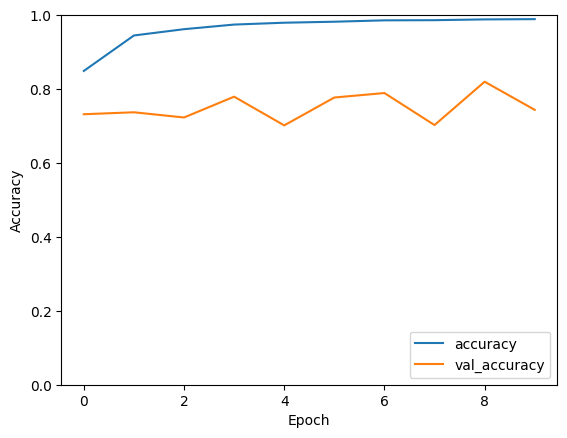

In [24]:
# Plot the feature importances
tf.keras.utils.plot_model(best_model, to_file='best_lstm_model.png', show_shapes=True, show_layer_names=True)

# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

update architecture

In [25]:
from tensorflow.keras.layers import Bidirectional, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

In [26]:
# update architecture
def create_model_v1(trial):
    model = Sequential()
    model.add(Bidirectional(LSTM(units=trial.suggest_int('units_1', 32, 128), return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(BatchNormalization())
    model.add(Dropout(trial.suggest_float('dropout_1', 0.2, 0.5)))
    model.add(Bidirectional(LSTM(units=trial.suggest_int('units_2', 16, 64), return_sequences=True)))
    model.add(BatchNormalization())
    model.add(Dropout(trial.suggest_float('dropout_2', 0.2, 0.5)))
    model.add(Bidirectional(LSTM(units=trial.suggest_int('units_3', 16, 64))))
    model.add(BatchNormalization())
    model.add(Dropout(trial.suggest_float('dropout_3', 0.2, 0.5)))
    model.add(Dense(units=trial.suggest_int('dense_units', 32, 128), activation='relu'))
    model.add(Dense(units=len(label_encoder.classes_), activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=trial.suggest_float('learning rate', 1e-4, 1e-2)),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model


In [27]:
# Define the objective function for Optuna
def objective(trial):
    model = create_model(trial)
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(X_train, y_train_encoded, validation_data=(X_test, y_test_encoded),
                        epochs=50, batch_size=trial.suggest_int('batch_size', 32, 128),
                        verbose=0, callbacks=[early_stopping])

    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)
    accuracy = accuracy_score(y_test_encoded, y_pred)

    return accuracy

In [28]:
# Create a study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2024-06-21 18:22:15,540] A new study created in memory with name: no-name-b2d708b0-dfc2-4582-b2d8-1f2845a68bcb


932/932 [==============================] - 4s 4ms/step


[I 2024-06-21 18:24:25,406] Trial 0 finished with value: 0.8398295988192674 and parameters: {'units_1': 87, 'dropout_1': 0.33692866819002243, 'units_2': 23, 'dropout_2': 0.3916541832003477, 'dense_units': 83, 'learning_rate': 0.005758000047761582, 'batch_size': 99}. Best is trial 0 with value: 0.8398295988192674.


932/932 [==============================] - 4s 4ms/step


[I 2024-06-21 18:26:26,742] Trial 1 finished with value: 0.8004159398899772 and parameters: {'units_1': 43, 'dropout_1': 0.4795173418279716, 'units_2': 33, 'dropout_2': 0.3013294105184401, 'dense_units': 109, 'learning_rate': 0.004800354722225288, 'batch_size': 124}. Best is trial 0 with value: 0.8398295988192674.


932/932 [==============================] - 4s 4ms/step


[I 2024-06-21 18:30:04,619] Trial 2 finished with value: 0.7948812558701194 and parameters: {'units_1': 116, 'dropout_1': 0.2169287892871622, 'units_2': 20, 'dropout_2': 0.29118709833055817, 'dense_units': 37, 'learning_rate': 0.003926484261235366, 'batch_size': 64}. Best is trial 0 with value: 0.8398295988192674.


932/932 [==============================] - 4s 4ms/step


[I 2024-06-21 18:33:13,459] Trial 3 finished with value: 0.6538977592915605 and parameters: {'units_1': 93, 'dropout_1': 0.4885702059529476, 'units_2': 60, 'dropout_2': 0.20776144726792536, 'dense_units': 128, 'learning_rate': 0.00014228000275172167, 'batch_size': 101}. Best is trial 0 with value: 0.8398295988192674.


932/932 [==============================] - 4s 4ms/step


[I 2024-06-21 18:35:12,656] Trial 4 finished with value: 0.7542264859788005 and parameters: {'units_1': 102, 'dropout_1': 0.47297357296754505, 'units_2': 17, 'dropout_2': 0.3071323939622294, 'dense_units': 50, 'learning_rate': 0.0016049025127158802, 'batch_size': 116}. Best is trial 0 with value: 0.8398295988192674.


932/932 [==============================] - 4s 4ms/step


[I 2024-06-21 18:38:07,509] Trial 5 finished with value: 0.7072319871192808 and parameters: {'units_1': 44, 'dropout_1': 0.4157642577438277, 'units_2': 60, 'dropout_2': 0.43722091076686387, 'dense_units': 53, 'learning_rate': 0.00500704839268762, 'batch_size': 111}. Best is trial 0 with value: 0.8398295988192674.


932/932 [==============================] - 4s 4ms/step


[I 2024-06-21 18:44:23,861] Trial 6 finished with value: 0.8016570508520059 and parameters: {'units_1': 74, 'dropout_1': 0.2249490050750475, 'units_2': 48, 'dropout_2': 0.32935959672058057, 'dense_units': 34, 'learning_rate': 0.0038197390333457593, 'batch_size': 57}. Best is trial 0 with value: 0.8398295988192674.


932/932 [==============================] - 4s 4ms/step


[I 2024-06-21 18:46:37,107] Trial 7 finished with value: 0.792633838722662 and parameters: {'units_1': 44, 'dropout_1': 0.23025262668187013, 'units_2': 52, 'dropout_2': 0.28760653466045394, 'dense_units': 33, 'learning_rate': 0.009417236603593377, 'batch_size': 72}. Best is trial 0 with value: 0.8398295988192674.


932/932 [==============================] - 4s 4ms/step


[I 2024-06-21 18:49:26,049] Trial 8 finished with value: 0.7697571447739165 and parameters: {'units_1': 42, 'dropout_1': 0.3761871271229969, 'units_2': 64, 'dropout_2': 0.48345068169456473, 'dense_units': 97, 'learning_rate': 0.004587088913423679, 'batch_size': 94}. Best is trial 0 with value: 0.8398295988192674.


932/932 [==============================] - 4s 4ms/step


[I 2024-06-21 18:50:54,692] Trial 9 finished with value: 0.6528243660271031 and parameters: {'units_1': 45, 'dropout_1': 0.37779178206450836, 'units_2': 26, 'dropout_2': 0.45809501205529, 'dense_units': 47, 'learning_rate': 0.0010879479989018112, 'batch_size': 94}. Best is trial 0 with value: 0.8398295988192674.


932/932 [==============================] - 4s 4ms/step


[I 2024-06-21 19:03:09,159] Trial 10 finished with value: 0.6637595599087616 and parameters: {'units_1': 71, 'dropout_1': 0.30526701618296637, 'units_2': 37, 'dropout_2': 0.40415013433363334, 'dense_units': 72, 'learning_rate': 0.007958822876978489, 'batch_size': 32}. Best is trial 0 with value: 0.8398295988192674.


932/932 [==============================] - 4s 4ms/step


[I 2024-06-21 19:08:39,692] Trial 11 finished with value: 0.7690191869046021 and parameters: {'units_1': 72, 'dropout_1': 0.28955072342763943, 'units_2': 47, 'dropout_2': 0.3758149455755521, 'dense_units': 76, 'learning_rate': 0.007011904902313727, 'batch_size': 51}. Best is trial 0 with value: 0.8398295988192674.


932/932 [==============================] - 4s 4ms/step


[I 2024-06-21 19:12:17,736] Trial 12 finished with value: 0.7851871729504898 and parameters: {'units_1': 86, 'dropout_1': 0.28386216369662753, 'units_2': 47, 'dropout_2': 0.34193789494736926, 'dense_units': 90, 'learning_rate': 0.0031994186288703402, 'batch_size': 54}. Best is trial 0 with value: 0.8398295988192674.


932/932 [==============================] - 4s 4ms/step


[I 2024-06-21 19:14:13,141] Trial 13 finished with value: 0.733664296256541 and parameters: {'units_1': 64, 'dropout_1': 0.2609482276296274, 'units_2': 28, 'dropout_2': 0.3621174518200527, 'dense_units': 66, 'learning_rate': 0.006243441869524255, 'batch_size': 81}. Best is trial 0 with value: 0.8398295988192674.


932/932 [==============================] - 4s 4ms/step


[I 2024-06-21 19:20:01,984] Trial 14 finished with value: 0.7572118609955723 and parameters: {'units_1': 108, 'dropout_1': 0.32130590299844397, 'units_2': 42, 'dropout_2': 0.22841710534379617, 'dense_units': 93, 'learning_rate': 0.00258307116515083, 'batch_size': 37}. Best is trial 0 with value: 0.8398295988192674.


932/932 [==============================] - 4s 4ms/step


[I 2024-06-21 19:22:13,668] Trial 15 finished with value: 0.780122098483832 and parameters: {'units_1': 61, 'dropout_1': 0.349214599543651, 'units_2': 52, 'dropout_2': 0.3982371537850617, 'dense_units': 61, 'learning_rate': 0.0060826255598961316, 'batch_size': 82}. Best is trial 0 with value: 0.8398295988192674.


932/932 [==============================] - 4s 4ms/step


[I 2024-06-21 19:28:08,157] Trial 16 finished with value: 0.6995505165705085 and parameters: {'units_1': 90, 'dropout_1': 0.2003207186038187, 'units_2': 32, 'dropout_2': 0.3351163345570506, 'dense_units': 82, 'learning_rate': 0.008154689327654516, 'batch_size': 54}. Best is trial 0 with value: 0.8398295988192674.


932/932 [==============================] - 4s 4ms/step


[I 2024-06-21 19:30:37,807] Trial 17 finished with value: 0.7633838722662015 and parameters: {'units_1': 125, 'dropout_1': 0.43475513910768065, 'units_2': 24, 'dropout_2': 0.2554160198975539, 'dense_units': 116, 'learning_rate': 0.0030856800738257527, 'batch_size': 63}. Best is trial 0 with value: 0.8398295988192674.


932/932 [==============================] - 4s 4ms/step


[I 2024-06-21 19:32:26,178] Trial 18 finished with value: 0.8043069904736347 and parameters: {'units_1': 79, 'dropout_1': 0.24900022718909687, 'units_2': 41, 'dropout_2': 0.417892786056438, 'dense_units': 105, 'learning_rate': 0.006201255621487925, 'batch_size': 90}. Best is trial 0 with value: 0.8398295988192674.


932/932 [==============================] - 4s 4ms/step


[I 2024-06-21 19:33:50,649] Trial 19 finished with value: 0.7915604454582047 and parameters: {'units_1': 99, 'dropout_1': 0.25030272625335304, 'units_2': 39, 'dropout_2': 0.42582550316069373, 'dense_units': 105, 'learning_rate': 0.009712096874389493, 'batch_size': 103}. Best is trial 0 with value: 0.8398295988192674.


932/932 [==============================] - 4s 4ms/step


[I 2024-06-21 19:35:40,062] Trial 20 finished with value: 0.8200053669663223 and parameters: {'units_1': 82, 'dropout_1': 0.3353831943177196, 'units_2': 33, 'dropout_2': 0.496372077724698, 'dense_units': 122, 'learning_rate': 0.005981822968187538, 'batch_size': 89}. Best is trial 0 with value: 0.8398295988192674.


932/932 [==============================] - 4s 4ms/step


[I 2024-06-21 19:38:21,964] Trial 21 finished with value: 0.7938749496846907 and parameters: {'units_1': 81, 'dropout_1': 0.33546294399316384, 'units_2': 32, 'dropout_2': 0.4908461756961333, 'dense_units': 128, 'learning_rate': 0.006055541148380592, 'batch_size': 89}. Best is trial 0 with value: 0.8398295988192674.


932/932 [==============================] - 4s 4ms/step


[I 2024-06-21 19:40:09,122] Trial 22 finished with value: 0.8019589427076345 and parameters: {'units_1': 61, 'dropout_1': 0.3824521405067302, 'units_2': 22, 'dropout_2': 0.446245860782882, 'dense_units': 118, 'learning_rate': 0.007045623667839505, 'batch_size': 105}. Best is trial 0 with value: 0.8398295988192674.


932/932 [==============================] - 4s 4ms/step


[I 2024-06-21 19:42:00,496] Trial 23 finished with value: 0.771434321749631 and parameters: {'units_1': 84, 'dropout_1': 0.2741256066175917, 'units_2': 29, 'dropout_2': 0.40380548819747636, 'dense_units': 104, 'learning_rate': 0.006981347125919232, 'batch_size': 88}. Best is trial 0 with value: 0.8398295988192674.


932/932 [==============================] - 4s 4ms/step


[I 2024-06-21 19:44:15,115] Trial 24 finished with value: 0.7953508654233195 and parameters: {'units_1': 97, 'dropout_1': 0.3201196303532432, 'units_2': 35, 'dropout_2': 0.46845758976973245, 'dense_units': 118, 'learning_rate': 0.00563268302558636, 'batch_size': 73}. Best is trial 0 with value: 0.8398295988192674.


932/932 [==============================] - 4s 4ms/step


[I 2024-06-21 19:46:52,300] Trial 25 finished with value: 0.7973634777941768 and parameters: {'units_1': 75, 'dropout_1': 0.4100430917636951, 'units_2': 42, 'dropout_2': 0.37273863783060396, 'dense_units': 83, 'learning_rate': 0.00781411664396929, 'batch_size': 96}. Best is trial 0 with value: 0.8398295988192674.


932/932 [==============================] - 4s 4ms/step


[I 2024-06-21 19:49:00,436] Trial 26 finished with value: 0.7900174426405474 and parameters: {'units_1': 53, 'dropout_1': 0.3601137937199276, 'units_2': 16, 'dropout_2': 0.49678801128067906, 'dense_units': 99, 'learning_rate': 0.005408899735312243, 'batch_size': 113}. Best is trial 0 with value: 0.8398295988192674.


932/932 [==============================] - 4s 4ms/step


[I 2024-06-21 19:50:11,411] Trial 27 finished with value: 0.6987790151616798 and parameters: {'units_1': 106, 'dropout_1': 0.29983628810397767, 'units_2': 30, 'dropout_2': 0.4232091931225391, 'dense_units': 111, 'learning_rate': 0.008642725986714991, 'batch_size': 127}. Best is trial 0 with value: 0.8398295988192674.


932/932 [==============================] - 4s 4ms/step


[I 2024-06-21 19:53:25,278] Trial 28 finished with value: 0.7856903260432041 and parameters: {'units_1': 89, 'dropout_1': 0.256626522447796, 'units_2': 38, 'dropout_2': 0.3911714575784502, 'dense_units': 89, 'learning_rate': 0.00669552160589632, 'batch_size': 76}. Best is trial 0 with value: 0.8398295988192674.


932/932 [==============================] - 4s 4ms/step


[I 2024-06-21 19:55:00,015] Trial 29 finished with value: 0.7655642023346303 and parameters: {'units_1': 68, 'dropout_1': 0.3430742319623524, 'units_2': 35, 'dropout_2': 0.4681593606015975, 'dense_units': 111, 'learning_rate': 0.004304204420514259, 'batch_size': 118}. Best is trial 0 with value: 0.8398295988192674.


932/932 [==============================] - 4s 4ms/step


[I 2024-06-21 19:56:35,350] Trial 30 finished with value: 0.8011538977592916 and parameters: {'units_1': 79, 'dropout_1': 0.44663733416944096, 'units_2': 20, 'dropout_2': 0.4220023477617422, 'dense_units': 122, 'learning_rate': 0.005553874601468683, 'batch_size': 89}. Best is trial 0 with value: 0.8398295988192674.


932/932 [==============================] - 4s 4ms/step


[I 2024-06-21 19:59:05,600] Trial 31 finished with value: 0.7868978934657185 and parameters: {'units_1': 59, 'dropout_1': 0.38067004017625267, 'units_2': 23, 'dropout_2': 0.4538345263565461, 'dense_units': 119, 'learning_rate': 0.007226690125641911, 'batch_size': 105}. Best is trial 0 with value: 0.8398295988192674.


932/932 [==============================] - 4s 4ms/step


[I 2024-06-21 20:00:25,070] Trial 32 finished with value: 0.7797195760096606 and parameters: {'units_1': 32, 'dropout_1': 0.39882521939202104, 'units_2': 21, 'dropout_2': 0.4403202028523189, 'dense_units': 109, 'learning_rate': 0.007456792879242059, 'batch_size': 104}. Best is trial 0 with value: 0.8398295988192674.


932/932 [==============================] - 4s 4ms/step


[I 2024-06-21 20:02:26,760] Trial 33 finished with value: 0.7856232389641755 and parameters: {'units_1': 55, 'dropout_1': 0.35974889509586394, 'units_2': 25, 'dropout_2': 0.47517847809780633, 'dense_units': 123, 'learning_rate': 0.006571928359528621, 'batch_size': 109}. Best is trial 0 with value: 0.8398295988192674.


932/932 [==============================] - 4s 4ms/step


[I 2024-06-21 20:03:57,904] Trial 34 finished with value: 0.7294713538172548 and parameters: {'units_1': 78, 'dropout_1': 0.31499262036733533, 'units_2': 19, 'dropout_2': 0.4538372881751247, 'dense_units': 101, 'learning_rate': 0.00870455023638144, 'batch_size': 98}. Best is trial 0 with value: 0.8398295988192674.


932/932 [==============================] - 4s 4ms/step


[I 2024-06-21 20:05:21,555] Trial 35 finished with value: 0.8178585804374078 and parameters: {'units_1': 93, 'dropout_1': 0.47138961479202135, 'units_2': 42, 'dropout_2': 0.4383083576533884, 'dense_units': 114, 'learning_rate': 0.005129786440027268, 'batch_size': 122}. Best is trial 0 with value: 0.8398295988192674.


932/932 [==============================] - 4s 4ms/step


[I 2024-06-21 20:06:45,755] Trial 36 finished with value: 0.7621763048436871 and parameters: {'units_1': 93, 'dropout_1': 0.46464630620161795, 'units_2': 41, 'dropout_2': 0.4277641751251301, 'dense_units': 128, 'learning_rate': 0.005097009366973577, 'batch_size': 120}. Best is trial 0 with value: 0.8398295988192674.


932/932 [==============================] - 4s 4ms/step


[I 2024-06-21 20:08:01,973] Trial 37 finished with value: 0.8161814034616933 and parameters: {'units_1': 117, 'dropout_1': 0.23839264664350618, 'units_2': 46, 'dropout_2': 0.3838328625851009, 'dense_units': 111, 'learning_rate': 0.004203995929168056, 'batch_size': 124}. Best is trial 0 with value: 0.8398295988192674.


932/932 [==============================] - 4s 4ms/step


[I 2024-06-21 20:10:49,222] Trial 38 finished with value: 0.7829732993425467 and parameters: {'units_1': 119, 'dropout_1': 0.43947178478887317, 'units_2': 44, 'dropout_2': 0.3815606425338824, 'dense_units': 114, 'learning_rate': 0.004083593251509083, 'batch_size': 122}. Best is trial 0 with value: 0.8398295988192674.


932/932 [==============================] - 4s 4ms/step


[I 2024-06-21 20:14:19,260] Trial 39 finished with value: 0.8137662686166645 and parameters: {'units_1': 112, 'dropout_1': 0.47413017061891866, 'units_2': 44, 'dropout_2': 0.314761565578683, 'dense_units': 94, 'learning_rate': 0.004716804935706596, 'batch_size': 127}. Best is trial 0 with value: 0.8398295988192674.


932/932 [==============================] - 4s 4ms/step


[I 2024-06-21 20:15:42,097] Trial 40 finished with value: 0.7705286461827452 and parameters: {'units_1': 125, 'dropout_1': 0.4957968228469983, 'units_2': 52, 'dropout_2': 0.3671501905259121, 'dense_units': 123, 'learning_rate': 0.0036743780503075245, 'batch_size': 114}. Best is trial 0 with value: 0.8398295988192674.


932/932 [==============================] - 4s 4ms/step


[I 2024-06-21 20:17:11,003] Trial 41 finished with value: 0.7847846504763183 and parameters: {'units_1': 113, 'dropout_1': 0.4623103953256153, 'units_2': 49, 'dropout_2': 0.2919006559004468, 'dense_units': 95, 'learning_rate': 0.004749829493419069, 'batch_size': 124}. Best is trial 0 with value: 0.8398295988192674.


932/932 [==============================] - 4s 4ms/step


[I 2024-06-21 20:18:25,842] Trial 42 finished with value: 0.7267543271165974 and parameters: {'units_1': 119, 'dropout_1': 0.47151085917626145, 'units_2': 45, 'dropout_2': 0.31839878008422506, 'dense_units': 88, 'learning_rate': 0.0050740203860355415, 'batch_size': 128}. Best is trial 0 with value: 0.8398295988192674.


932/932 [==============================] - 4s 4ms/step


[I 2024-06-21 20:20:09,897] Trial 43 finished with value: 0.8087011941500067 and parameters: {'units_1': 106, 'dropout_1': 0.4841779649536535, 'units_2': 50, 'dropout_2': 0.34788743040802295, 'dense_units': 75, 'learning_rate': 0.004620575795580354, 'batch_size': 110}. Best is trial 0 with value: 0.8398295988192674.


932/932 [==============================] - 4s 4ms/step


[I 2024-06-21 20:22:16,226] Trial 44 finished with value: 0.832013954112438 and parameters: {'units_1': 111, 'dropout_1': 0.45672484265798086, 'units_2': 54, 'dropout_2': 0.2760098373730812, 'dense_units': 108, 'learning_rate': 0.003458395554678175, 'batch_size': 117}. Best is trial 0 with value: 0.8398295988192674.


932/932 [==============================] - 4s 4ms/step


[I 2024-06-21 20:24:57,676] Trial 45 finished with value: 0.7610693680397156 and parameters: {'units_1': 100, 'dropout_1': 0.4249695922132243, 'units_2': 57, 'dropout_2': 0.26796470361752595, 'dense_units': 110, 'learning_rate': 0.0024799492235353425, 'batch_size': 117}. Best is trial 0 with value: 0.8398295988192674.


932/932 [==============================] - 4s 4ms/step


[I 2024-06-21 20:27:10,001] Trial 46 finished with value: 0.8091708037032067 and parameters: {'units_1': 94, 'dropout_1': 0.39421503410635317, 'units_2': 60, 'dropout_2': 0.35635171729984766, 'dense_units': 107, 'learning_rate': 0.003610413132799974, 'batch_size': 99}. Best is trial 0 with value: 0.8398295988192674.


932/932 [==============================] - 4s 4ms/step


[I 2024-06-21 20:29:29,504] Trial 47 finished with value: 0.7813632094458607 and parameters: {'units_1': 128, 'dropout_1': 0.4546933100174056, 'units_2': 56, 'dropout_2': 0.2060510491700174, 'dense_units': 40, 'learning_rate': 0.0022753925097898555, 'batch_size': 109}. Best is trial 0 with value: 0.8398295988192674.


932/932 [==============================] - 4s 4ms/step


[I 2024-06-21 20:31:50,099] Trial 48 finished with value: 0.852173621360526 and parameters: {'units_1': 103, 'dropout_1': 0.22533842840317808, 'units_2': 55, 'dropout_2': 0.22651653925108772, 'dense_units': 61, 'learning_rate': 0.0019277191666681854, 'batch_size': 84}. Best is trial 48 with value: 0.852173621360526.


932/932 [==============================] - 4s 4ms/step


[I 2024-06-21 20:33:39,195] Trial 49 finished with value: 0.6499396216288743 and parameters: {'units_1': 85, 'dropout_1': 0.20530487134000736, 'units_2': 55, 'dropout_2': 0.2502141417384582, 'dense_units': 56, 'learning_rate': 0.000723763646597528, 'batch_size': 82}. Best is trial 48 with value: 0.852173621360526.


In [29]:
# Print best hyperparameters
print('Best hyperparameters:', study.best_params)

# Visualize the optimization history
optuna.visualization.plot_optimization_history(study)
plt.show()

# Visualize the hyperparameter importance
optuna.visualization.plot_param_importances(study)
plt.show()

Best hyperparameters: {'units_1': 103, 'dropout_1': 0.22533842840317808, 'units_2': 55, 'dropout_2': 0.22651653925108772, 'dense_units': 61, 'learning_rate': 0.0019277191666681854, 'batch_size': 84}


In [30]:
# Train the best model using the best hyperparameters
best_trial = study.best_trial
best_model = create_model(best_trial)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
best_model.fit(X_train, y_train_encoded, validation_data=(X_test, y_test_encoded),
               epochs=50, batch_size=best_trial.params['batch_size'],
               verbose=1, callbacks=[early_stopping])

Epoch 1/50
1775/1775 [==============================] - 21s 10ms/step - loss: 0.3351 - accuracy: 0.8672 - val_loss: 1.1196 - val_accuracy: 0.7494
Epoch 2/50
1775/1775 [==============================] - 17s 10ms/step - loss: 0.0786 - accuracy: 0.9731 - val_loss: 1.1152 - val_accuracy: 0.7839
Epoch 3/50
1775/1775 [==============================] - 17s 10ms/step - loss: 0.0499 - accuracy: 0.9827 - val_loss: 1.1111 - val_accuracy: 0.7800
Epoch 4/50
1775/1775 [==============================] - 17s 10ms/step - loss: 0.0393 - accuracy: 0.9865 - val_loss: 1.5403 - val_accuracy: 0.7703
Epoch 5/50
1775/1775 [==============================] - 17s 10ms/step - loss: 0.0336 - accuracy: 0.9886 - val_loss: 1.1755 - val_accuracy: 0.7846
Epoch 6/50
1775/1775 [==============================] - 17s 10ms/step - loss: 0.0282 - accuracy: 0.9904 - val_loss: 0.8721 - val_accuracy: 0.8059
Epoch 7/50
1775/1775 [==============================] - 18s 10ms/step - loss: 0.0261 - accuracy: 0.9913 - val_loss: 0.9653 -

932/932 [==============================] - 4s 4ms/step
Accuracy of the best model: 0.7548973567690863
Classification Report:
              precision    recall  f1-score   support

          FB       0.97      0.98      0.98      5996
       Insta       0.98      0.99      0.98      5951
      Reddit       0.41      0.36      0.38      5955
      TikTok       0.42      0.47      0.44      5955
           X       0.99      0.97      0.98      5955

    accuracy                           0.75     29812
   macro avg       0.75      0.75      0.75     29812
weighted avg       0.75      0.75      0.75     29812



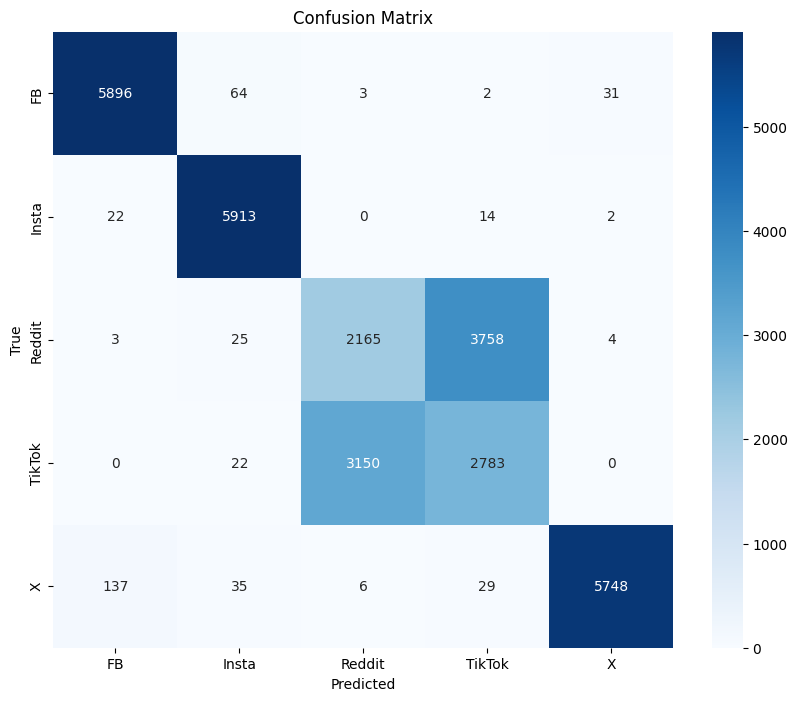

In [31]:
# Evaluate the best model
y_pred_prob = best_model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
accuracy = accuracy_score(y_test_encoded, y_pred)
print(f"Accuracy of the best model: {accuracy}")

# Print classification report
print("Classification Report:")
print(classification_report(y_test_encoded, y_pred, target_names=label_encoder.classes_))

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [32]:
from keras.callbacks import ReduceLROnPlateau

# Reduce learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.001)

# Early stopping callback with higher patience
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with the best hyperparameters found
best_model.fit(X_train, y_train_encoded, validation_data=(X_test, y_test_encoded),
               epochs=50, batch_size=best_trial.params['batch_size'],
               verbose=1, callbacks=[early_stopping, reduce_lr])


Epoch 1/50
1775/1775 [==============================] - 17s 10ms/step - loss: 0.0172 - accuracy: 0.9945 - val_loss: 0.9229 - val_accuracy: 0.8200 - lr: 0.0019
Epoch 2/50
1775/1775 [==============================] - 18s 10ms/step - loss: 0.0161 - accuracy: 0.9948 - val_loss: 1.1417 - val_accuracy: 0.7901 - lr: 0.0019
Epoch 3/50
1775/1775 [==============================] - 18s 10ms/step - loss: 0.0125 - accuracy: 0.9961 - val_loss: 1.3462 - val_accuracy: 0.7919 - lr: 0.0019
Epoch 4/50
1775/1775 [==============================] - 18s 10ms/step - loss: 0.0142 - accuracy: 0.9955 - val_loss: 1.5690 - val_accuracy: 0.8029 - lr: 0.0019
Epoch 5/50
1775/1775 [==============================] - 18s 10ms/step - loss: 0.0059 - accuracy: 0.9979 - val_loss: 1.8538 - val_accuracy: 0.8043 - lr: 0.0010
Epoch 6/50
1775/1775 [==============================] - 17s 10ms/step - loss: 0.0065 - accuracy: 0.9983 - val_loss: 1.6458 - val_accuracy: 0.7988 - lr: 0.0010
Epoch 7/50
1775/1775 [========================

932/932 [==============================] - 4s 4ms/step
Accuracy of the best model: 0.819971823426808
Classification Report:
              precision    recall  f1-score   support

          FB       0.99      0.98      0.99      5996
       Insta       0.99      1.00      1.00      5951
      Reddit       0.58      0.49      0.53      5955
      TikTok       0.56      0.64      0.59      5955
           X       0.99      0.99      0.99      5955

    accuracy                           0.82     29812
   macro avg       0.82      0.82      0.82     29812
weighted avg       0.82      0.82      0.82     29812



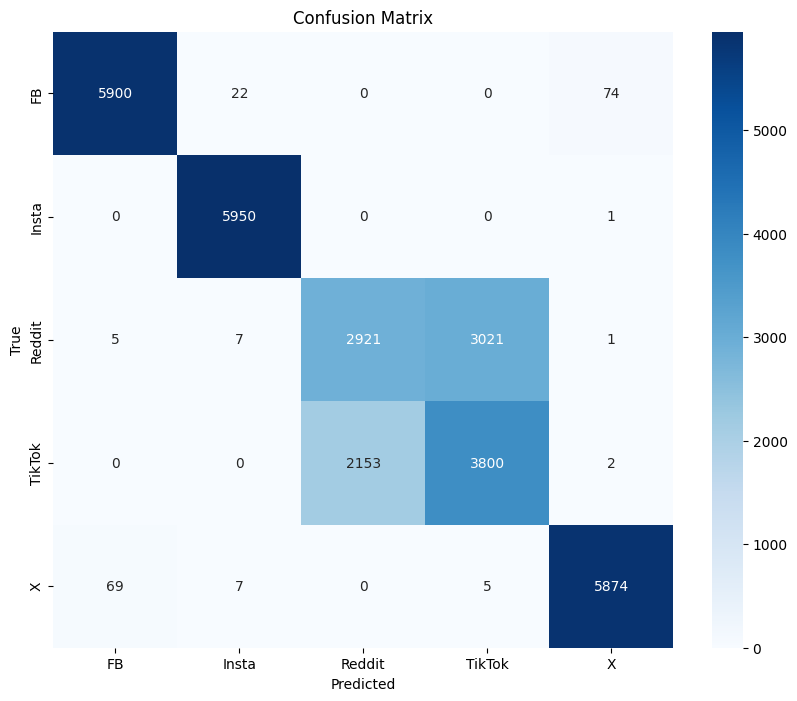

In [33]:
# Evaluate the best model
y_pred_prob = best_model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
accuracy = accuracy_score(y_test_encoded, y_pred)
print(f"Accuracy of the best model: {accuracy}")

# Print classification report
print("Classification Report:")
print(classification_report(y_test_encoded, y_pred, target_names=label_encoder.classes_))

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

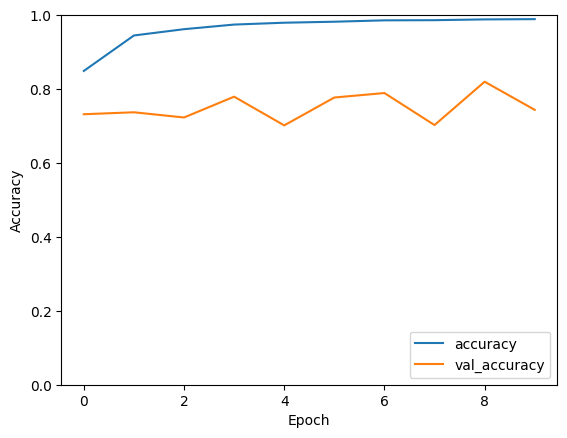

In [34]:
# Plot the feature importances
tf.keras.utils.plot_model(best_model, to_file='best_lstm_model.png', show_shapes=True, show_layer_names=True)

# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()